# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   int                     1206 non-null   int64  
 1   level                   1206 non-null   int64  
 2   num_immunities          1206 non-null   int64  
 3   con                     1206 non-null   int64  
 4   will                    1206 non-null   int64  
 5   ac                      1206 non-null   int64  
 6   str                     1206 non-null   int64  
 7   hp                      1206 non-null   int64  
 8   cha                     1206 non-null   int64  
 9   perception              1206 non-null   int64  
 10  fortitude               1206 non-null   int64  
 11  focus                   1206 non-null   int32  
 12  wis                     1206 non-null   int64  
 13  land_speed              1206 non-null   float64
 14  dex                     1206 non-null   

In [3]:
df.head()

,int,level,num_immunities,con,will,ac,str,hp,cha,perception,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,1,10,3,5,17,29,7,215,1,20,...,0,0,0,0,0,0,23,22.0,0,0.0
1,-4,10,0,5,16,28,9,220,1,16,...,0,0,0,0,0,0,23,22.0,0,0.0
2,-4,8,0,6,15,25,7,175,-2,17,...,0,0,0,0,0,0,21,16.0,0,0.0
3,6,17,3,5,32,41,7,315,6,30,...,1,0,1,0,0,0,33,31.5,0,0.0
4,-1,1,0,1,4,16,-5,20,1,6,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


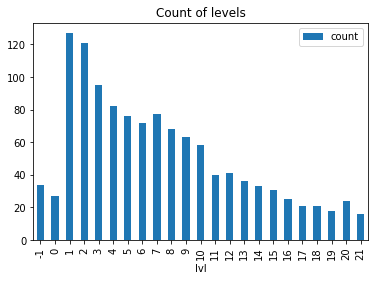

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.460853	valid_0's l2: 0.927292


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.96
MAE: 0.46


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.12
RMSE test: 0.96


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

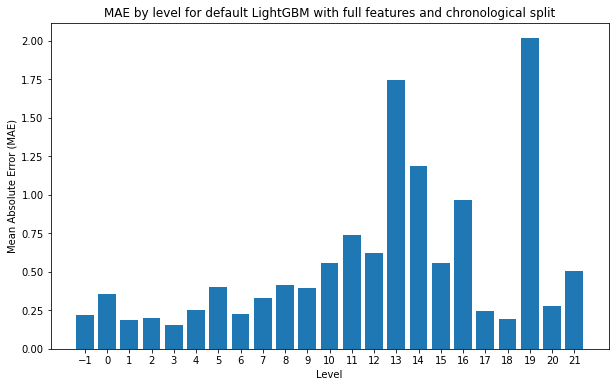

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.96

Round type: 0.5
RMSE: 0.98

Round type: 0.33
RMSE: 0.95

Round type: 0.45
RMSE: 0.96



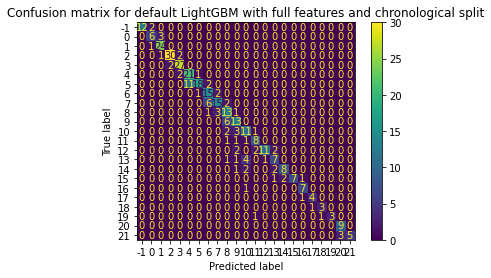

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with full features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 13:56:58,820] A new study created in memory with name: no-name-35f23fc2-12c8-4a24-ad47-4c550d1cc9a7
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.150665 + 0.0364174
[200]	cv_agg's l2: 0.148526 + 0.035229
[300]	cv_agg's l2: 0.147961 + 0.0355227
[400]	cv_agg's l2: 0.147825 + 0.0357864


feature_fraction, val_score: 0.147628:  14%|######4                                      | 1/7 [00:08<00:53,  8.93s/it]

Early stopping, best iteration is:
[331]	cv_agg's l2: 0.147628 + 0.0354611
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


feature_fraction, val_score: 0.130643:  29%|############8                                | 2/7 [00:16<00:40,  8.12s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.134122 + 0.0272516
[200]	cv_agg's l2: 0.131818 + 0.0248679
[300]	cv_agg's l2: 0.131424 + 0.024509
[400]	cv_agg's l2: 0.131368 + 0.0242714


feature_fraction, val_score: 0.130643:  43%|###################2                         | 3/7 [00:23<00:30,  7.63s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.144204 + 0.0326398
[200]	cv_agg's l2: 0.140463 + 0.0313273
[300]	cv_agg's l2: 0.140176 + 0.0316848
[400]	cv_agg's l2: 0.14047 + 0.031658


feature_fraction, val_score: 0.130643:  57%|#########################7                   | 4/7 [00:30<00:22,  7.39s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.142486 + 0.0309103
[200]	cv_agg's l2: 0.139574 + 0.0294592
[300]	cv_agg's l2: 0.139082 + 0.0295514
[400]	cv_agg's l2: 0.138817 + 0.0294528


feature_fraction, val_score: 0.130643:  71%|################################1            | 5/7 [00:37<00:14,  7.09s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.14454 + 0.034287
[200]	cv_agg's l2: 0.142961 + 0.0340269
[300]	cv_agg's l2: 0.142266 + 0.0335688
[400]	cv_agg's l2: 0.142401 + 0.0338913


feature_fraction, val_score: 0.130643:  86%|######################################5      | 6/7 [00:45<00:07,  7.41s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.144773 + 0.0323578
[200]	cv_agg's l2: 0.14182 + 0.0314689
[300]	cv_agg's l2: 0.141437 + 0.0313515
[400]	cv_agg's l2: 0.141157 + 0.0313057


feature_fraction, val_score: 0.130643: 100%|#############################################| 7/7 [00:51<00:00,  7.42s/it]


Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677


num_leaves, val_score: 0.130643:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:   5%|##5                                               | 1/20 [00:08<02:44,  8.66s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131588 + 0.0275737
[300]	cv_agg's l2: 0.131041 + 0.0275296
[400]	cv_agg's l2: 0.131102 + 0.0271377


num_leaves, val_score: 0.130643:  10%|#####                                             | 2/20 [00:15<02:19,  7.73s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  15%|#######5                                          | 3/20 [00:23<02:08,  7.57s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.143138 + 0.0286939
[200]	cv_agg's l2: 0.136358 + 0.0258479
[300]	cv_agg's l2: 0.135583 + 0.0250125
[400]	cv_agg's l2: 0.135477 + 0.0245002


num_leaves, val_score: 0.130643:  20%|##########                                        | 4/20 [00:27<01:40,  6.28s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  25%|############5                                     | 5/20 [00:35<01:42,  6.83s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  30%|###############                                   | 6/20 [00:43<01:41,  7.24s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  35%|#################5                                | 7/20 [00:51<01:38,  7.55s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  40%|####################                              | 8/20 [00:59<01:34,  7.86s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  45%|######################5                           | 9/20 [01:08<01:30,  8.20s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  50%|########################5                        | 10/20 [01:18<01:27,  8.71s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  55%|##########################9                      | 11/20 [01:29<01:24,  9.40s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  60%|#############################4                   | 12/20 [01:39<01:15,  9.39s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  65%|###############################8                 | 13/20 [01:50<01:10, 10.10s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  70%|##################################3              | 14/20 [02:01<01:02, 10.40s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  75%|####################################7            | 15/20 [02:13<00:53, 10.77s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  80%|#######################################2         | 16/20 [02:24<00:43, 10.76s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  85%|#########################################6       | 17/20 [02:34<00:31, 10.55s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  90%|############################################1    | 18/20 [02:44<00:20, 10.45s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643:  95%|##############################################5  | 19/20 [02:56<00:10, 10.78s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.13632 + 0.0305262
[200]	cv_agg's l2: 0.131457 + 0.0277485
[300]	cv_agg's l2: 0.130898 + 0.0277215
[400]	cv_agg's l2: 0.130847 + 0.0273477


num_leaves, val_score: 0.130643: 100%|#################################################| 20/20 [03:07<00:00,  9.39s/it]


Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677


bagging, val_score: 0.130643:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.179195 + 0.0300828
[200]	cv_agg's l2: 0.172075 + 0.029609
[300]	cv_agg's l2: 0.169726 + 0.026279
[400]	cv_agg's l2: 0.16875 + 0.0241965


bagging, val_score: 0.130643:  10%|#####3                                               | 1/10 [00:06<00:54,  6.01s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.139105 + 0.0270118
[200]	cv_agg's l2: 0.135589 + 0.0245389
[300]	cv_agg's l2: 0.135154 + 0.0241637
[400]	cv_agg's l2: 0.134912 + 0.0244366


bagging, val_score: 0.130643:  20%|##########6                                          | 2/10 [00:23<01:41, 12.63s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.201847 + 0.0282686
[200]	cv_agg's l2: 0.186232 + 0.030481
[300]	cv_agg's l2: 0.183076 + 0.0349318
[400]	cv_agg's l2: 0.1827 + 0.0367137


bagging, val_score: 0.130643:  30%|###############9                                     | 3/10 [00:27<01:01,  8.83s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.154737 + 0.0353464
[200]	cv_agg's l2: 0.150475 + 0.0340681
[300]	cv_agg's l2: 0.150831 + 0.0346369
[400]	cv_agg's l2: 0.150736 + 0.0341114


bagging, val_score: 0.130643:  40%|#####################2                               | 4/10 [00:34<00:49,  8.22s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.136998 + 0.0270925
[200]	cv_agg's l2: 0.133432 + 0.0246103
[300]	cv_agg's l2: 0.132137 + 0.0244499
[400]	cv_agg's l2: 0.132228 + 0.0242362


bagging, val_score: 0.130643:  50%|##########################5                          | 5/10 [00:43<00:42,  8.41s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.170698 + 0.0349653
[200]	cv_agg's l2: 0.161512 + 0.0314802
[300]	cv_agg's l2: 0.159609 + 0.0283572
[400]	cv_agg's l2: 0.160589 + 0.0283884


bagging, val_score: 0.130643:  60%|###############################8                     | 6/10 [00:49<00:30,  7.67s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.161131 + 0.0365181
[200]	cv_agg's l2: 0.157902 + 0.0329145
[300]	cv_agg's l2: 0.158094 + 0.0318542
[400]	cv_agg's l2: 0.15857 + 0.032789


bagging, val_score: 0.130643:  70%|#####################################                | 7/10 [00:56<00:22,  7.44s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.170267 + 0.0216501
[200]	cv_agg's l2: 0.162699 + 0.026353
[300]	cv_agg's l2: 0.16279 + 0.0266363
[400]	cv_agg's l2: 0.162552 + 0.0244669


bagging, val_score: 0.130643:  80%|##########################################4          | 8/10 [01:02<00:13,  6.92s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.154485 + 0.0390696
[200]	cv_agg's l2: 0.14976 + 0.0380729
[300]	cv_agg's l2: 0.147444 + 0.0358497
[400]	cv_agg's l2: 0.14754 + 0.0353756


bagging, val_score: 0.130643:  90%|###############################################7     | 9/10 [01:11<00:07,  7.41s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.174978 + 0.0355533
[200]	cv_agg's l2: 0.165859 + 0.0344279
[300]	cv_agg's l2: 0.16535 + 0.0298008
[400]	cv_agg's l2: 0.16462 + 0.026092


bagging, val_score: 0.130643: 100%|####################################################| 10/10 [01:18<00:00,  7.87s/it]


Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677


feature_fraction_stage2, val_score: 0.130643:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.148965 + 0.0386458
[200]	cv_agg's l2: 0.144979 + 0.0370178
[300]	cv_agg's l2: 0.144161 + 0.0357932
[400]	cv_agg's l2: 0.143866 + 0.0349748


feature_fraction_stage2, val_score: 0.130643:  17%|######3                               | 1/6 [00:09<00:48,  9.69s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.141749 + 0.0282936
[200]	cv_agg's l2: 0.138342 + 0.0282231
[300]	cv_agg's l2: 0.137297 + 0.0265256
[400]	cv_agg's l2: 0.137154 + 0.0261782


feature_fraction_stage2, val_score: 0.130643:  33%|############6                         | 2/6 [00:18<00:35,  8.96s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.138415 + 0.0286472
[200]	cv_agg's l2: 0.135389 + 0.0260972
[300]	cv_agg's l2: 0.134693 + 0.0258208
[400]	cv_agg's l2: 0.134421 + 0.0258137


feature_fraction_stage2, val_score: 0.130643:  50%|###################                   | 3/6 [00:26<00:25,  8.65s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.14224 + 0.0333368
[200]	cv_agg's l2: 0.137869 + 0.031954
[300]	cv_agg's l2: 0.137393 + 0.031388
[400]	cv_agg's l2: 0.137207 + 0.0311258


feature_fraction_stage2, val_score: 0.130643:  67%|#########################3            | 4/6 [00:34<00:16,  8.35s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.136932 + 0.0312905
[200]	cv_agg's l2: 0.131756 + 0.0294936
[300]	cv_agg's l2: 0.131462 + 0.0293966
[400]	cv_agg's l2: 0.131162 + 0.0292877


feature_fraction_stage2, val_score: 0.130643:  83%|###############################6      | 5/6 [00:42<00:08,  8.45s/it]

Early stopping, best iteration is:
[365]	cv_agg's l2: 0.130643 + 0.0274677
[100]	cv_agg's l2: 0.132209 + 0.028162
[200]	cv_agg's l2: 0.130029 + 0.0254954
[300]	cv_agg's l2: 0.129447 + 0.0252933
[400]	cv_agg's l2: 0.128965 + 0.0248093
[500]	cv_agg's l2: 0.12898 + 0.0244286


feature_fraction_stage2, val_score: 0.128933: 100%|######################################| 6/6 [00:54<00:00,  9.02s/it]


Early stopping, best iteration is:
[489]	cv_agg's l2: 0.128933 + 0.0244935


regularization_factors, val_score: 0.128933:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.134565 + 0.0281956
[200]	cv_agg's l2: 0.131487 + 0.0279887
[300]	cv_agg's l2: 0.130844 + 0.0278171
[400]	cv_agg's l2: 0.130705 + 0.0273519
[500]	cv_agg's l2: 0.130977 + 0.0275226


regularization_factors, val_score: 0.128933:   5%|#9                                    | 1/20 [00:10<03:10, 10.03s/it]

Early stopping, best iteration is:
[489]	cv_agg's l2: 0.128933 + 0.0244935
[100]	cv_agg's l2: 0.155679 + 0.0332239
[200]	cv_agg's l2: 0.150715 + 0.0321698
[300]	cv_agg's l2: 0.150678 + 0.0322006
[400]	cv_agg's l2: 0.150679 + 0.0321891


regularization_factors, val_score: 0.128933:  10%|###8                                  | 2/20 [00:11<01:34,  5.26s/it]

[500]	cv_agg's l2: 0.150679 + 0.0321891
Early stopping, best iteration is:
[489]	cv_agg's l2: 0.128933 + 0.0244935
[100]	cv_agg's l2: 0.139678 + 0.0284682
[200]	cv_agg's l2: 0.134372 + 0.0257531
[300]	cv_agg's l2: 0.133332 + 0.0253409
[400]	cv_agg's l2: 0.132796 + 0.025067
[500]	cv_agg's l2: 0.132718 + 0.0247655


regularization_factors, val_score: 0.128933:  15%|#####7                                | 3/20 [00:18<01:40,  5.92s/it]

Early stopping, best iteration is:
[489]	cv_agg's l2: 0.128933 + 0.0244935
[100]	cv_agg's l2: 0.182586 + 0.0340454
[200]	cv_agg's l2: 0.180021 + 0.0331847
[300]	cv_agg's l2: 0.180016 + 0.0331873
[400]	cv_agg's l2: 0.180015 + 0.0331877
[500]	cv_agg's l2: 0.180015 + 0.0331877


regularization_factors, val_score: 0.128933:  20%|#######6                              | 4/20 [00:20<01:11,  4.45s/it]

Early stopping, best iteration is:
[489]	cv_agg's l2: 0.128933 + 0.0244935
[100]	cv_agg's l2: 0.132062 + 0.0284816
[200]	cv_agg's l2: 0.129391 + 0.0279108
[300]	cv_agg's l2: 0.128264 + 0.0277242
[400]	cv_agg's l2: 0.12802 + 0.0277882


regularization_factors, val_score: 0.127901:  25%|#########5                            | 5/20 [00:27<01:19,  5.28s/it]

Early stopping, best iteration is:
[383]	cv_agg's l2: 0.127901 + 0.0277743
[100]	cv_agg's l2: 0.132012 + 0.0284137
[200]	cv_agg's l2: 0.128539 + 0.0267754
[300]	cv_agg's l2: 0.127519 + 0.0265503
[400]	cv_agg's l2: 0.12728 + 0.0266421


regularization_factors, val_score: 0.127171:  30%|###########4                          | 6/20 [00:33<01:15,  5.37s/it]

Early stopping, best iteration is:
[368]	cv_agg's l2: 0.127171 + 0.0265941
[100]	cv_agg's l2: 0.13253 + 0.0286952
[200]	cv_agg's l2: 0.129052 + 0.0271762
[300]	cv_agg's l2: 0.128275 + 0.0272983
[400]	cv_agg's l2: 0.128199 + 0.0272483


regularization_factors, val_score: 0.127171:  35%|#############3                        | 7/20 [00:39<01:15,  5.82s/it]

Early stopping, best iteration is:
[368]	cv_agg's l2: 0.127171 + 0.0265941
[100]	cv_agg's l2: 0.131778 + 0.0281814
[200]	cv_agg's l2: 0.127699 + 0.0259842
[300]	cv_agg's l2: 0.127213 + 0.0257435
[400]	cv_agg's l2: 0.127206 + 0.0257704


regularization_factors, val_score: 0.127121:  40%|###############2                      | 8/20 [00:46<01:13,  6.09s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132062 + 0.0284816
[200]	cv_agg's l2: 0.129391 + 0.0279108
[300]	cv_agg's l2: 0.128311 + 0.0276133
[400]	cv_agg's l2: 0.127962 + 0.0275601


regularization_factors, val_score: 0.127121:  45%|#################1                    | 9/20 [00:52<01:05,  5.92s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132432 + 0.028991
[200]	cv_agg's l2: 0.129576 + 0.0281635
[300]	cv_agg's l2: 0.128512 + 0.0278912
[400]	cv_agg's l2: 0.128229 + 0.0279299


regularization_factors, val_score: 0.127121:  50%|##################5                  | 10/20 [00:59<01:02,  6.26s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132062 + 0.0284816
[200]	cv_agg's l2: 0.129391 + 0.0279108
[300]	cv_agg's l2: 0.128311 + 0.0276134
[400]	cv_agg's l2: 0.127962 + 0.0275601


regularization_factors, val_score: 0.127121:  55%|####################3                | 11/20 [01:06<00:58,  6.54s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132062 + 0.0284816
[200]	cv_agg's l2: 0.129392 + 0.0279108
[300]	cv_agg's l2: 0.128311 + 0.0276134
[400]	cv_agg's l2: 0.127962 + 0.0275601


regularization_factors, val_score: 0.127121:  60%|######################2              | 12/20 [01:13<00:53,  6.63s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132661 + 0.0288762
[200]	cv_agg's l2: 0.129757 + 0.0280669
[300]	cv_agg's l2: 0.128535 + 0.0278785
[400]	cv_agg's l2: 0.128226 + 0.0279318


regularization_factors, val_score: 0.127121:  65%|########################             | 13/20 [01:19<00:46,  6.63s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132012 + 0.0284137
[200]	cv_agg's l2: 0.128538 + 0.0267753
[300]	cv_agg's l2: 0.127519 + 0.0265503
[400]	cv_agg's l2: 0.12728 + 0.0266421


regularization_factors, val_score: 0.127121:  70%|#########################9           | 14/20 [01:25<00:38,  6.41s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.133541 + 0.0281867
[200]	cv_agg's l2: 0.130336 + 0.0265292
[300]	cv_agg's l2: 0.129583 + 0.0261556
[400]	cv_agg's l2: 0.129342 + 0.0262016


regularization_factors, val_score: 0.127121:  75%|###########################7         | 15/20 [01:31<00:30,  6.12s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.134566 + 0.0285065
[200]	cv_agg's l2: 0.131202 + 0.0268205
[300]	cv_agg's l2: 0.130623 + 0.0265611
[400]	cv_agg's l2: 0.130312 + 0.0263235


regularization_factors, val_score: 0.127121:  80%|#############################6       | 16/20 [01:36<00:23,  5.88s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132563 + 0.0286908
[200]	cv_agg's l2: 0.129281 + 0.0262578
[300]	cv_agg's l2: 0.128947 + 0.0263062
[400]	cv_agg's l2: 0.128903 + 0.0260749


regularization_factors, val_score: 0.127121:  85%|###############################4     | 17/20 [01:42<00:18,  6.05s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.136197 + 0.0259988
[200]	cv_agg's l2: 0.133748 + 0.0256071
[300]	cv_agg's l2: 0.133166 + 0.0251108
[400]	cv_agg's l2: 0.132614 + 0.0247754


regularization_factors, val_score: 0.127121:  90%|#################################3   | 18/20 [01:46<00:10,  5.41s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132266 + 0.0293847
[200]	cv_agg's l2: 0.129467 + 0.0271258
[300]	cv_agg's l2: 0.129151 + 0.0271825
[400]	cv_agg's l2: 0.128856 + 0.0271483


regularization_factors, val_score: 0.127121:  95%|###################################1 | 19/20 [01:50<00:04,  4.87s/it]

Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752
[100]	cv_agg's l2: 0.132637 + 0.0278195
[200]	cv_agg's l2: 0.129788 + 0.026274
[300]	cv_agg's l2: 0.129303 + 0.0264954
[400]	cv_agg's l2: 0.128971 + 0.0261166
Early stopping, best iteration is:
[332]	cv_agg's l2: 0.127121 + 0.0257752


min_data_in_leaf, val_score: 0.127121:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.125457 + 0.0196479
[200]	cv_agg's l2: 0.123724 + 0.0191578
[300]	cv_agg's l2: 0.123431 + 0.0191398
[400]	cv_agg's l2: 0.12338 + 0.0191318
[500]	cv_agg's l2: 0.123338 + 0.0191176


min_data_in_leaf, val_score: 0.123329:   0%|                                                     | 0/5 [00:05<?, ?it/s]

[600]	cv_agg's l2: 0.123344 + 0.0191249
Early stopping, best iteration is:
[531]	cv_agg's l2: 0.123329 + 0.0191162


min_data_in_leaf, val_score: 0.123329:  20%|#########                                    | 1/5 [00:05<00:20,  5.09s/it]

[100]	cv_agg's l2: 0.151484 + 0.0341525
[200]	cv_agg's l2: 0.147584 + 0.0309512
[300]	cv_agg's l2: 0.146429 + 0.0299722
[400]	cv_agg's l2: 0.146723 + 0.0297539
[500]	cv_agg's l2: 0.14705 + 0.030159


min_data_in_leaf, val_score: 0.123329:  40%|##################                           | 2/5 [00:09<00:13,  4.57s/it]

[600]	cv_agg's l2: 0.147594 + 0.0302891
Early stopping, best iteration is:
[531]	cv_agg's l2: 0.123329 + 0.0191162
[100]	cv_agg's l2: 0.228761 + 0.037933
[200]	cv_agg's l2: 0.215562 + 0.0411006
[300]	cv_agg's l2: 0.213807 + 0.0462736
[400]	cv_agg's l2: 0.212503 + 0.04621
[500]	cv_agg's l2: 0.212683 + 0.0497453


min_data_in_leaf, val_score: 0.123329:  60%|###########################                  | 3/5 [00:11<00:06,  3.47s/it]

[600]	cv_agg's l2: 0.213471 + 0.0518283
Early stopping, best iteration is:
[531]	cv_agg's l2: 0.123329 + 0.0191162
[100]	cv_agg's l2: 0.722704 + 0.107055
[200]	cv_agg's l2: 0.678773 + 0.116659
[300]	cv_agg's l2: 0.660278 + 0.120576
[400]	cv_agg's l2: 0.650657 + 0.124564
[500]	cv_agg's l2: 0.644937 + 0.125705


min_data_in_leaf, val_score: 0.123329:  80%|####################################         | 4/5 [00:13<00:02,  2.74s/it]

[600]	cv_agg's l2: 0.642111 + 0.124853
Early stopping, best iteration is:
[531]	cv_agg's l2: 0.123329 + 0.0191162
[100]	cv_agg's l2: 0.11871 + 0.020391
[200]	cv_agg's l2: 0.117119 + 0.0212315


min_data_in_leaf, val_score: 0.116989: 100%|#############################################| 5/5 [00:15<00:00,  3.09s/it]

[300]	cv_agg's l2: 0.117074 + 0.0212673
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.116989 + 0.0212612


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.11698883904428736
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.2167557112228009e-08
    lambda_l2: 0.0015947179724224542
    num_leaves: 31
    feature_fraction: 0.42
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.57
MAE test: 0.35



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "full",
    rmse,
    mae,
]

###### MAE by level

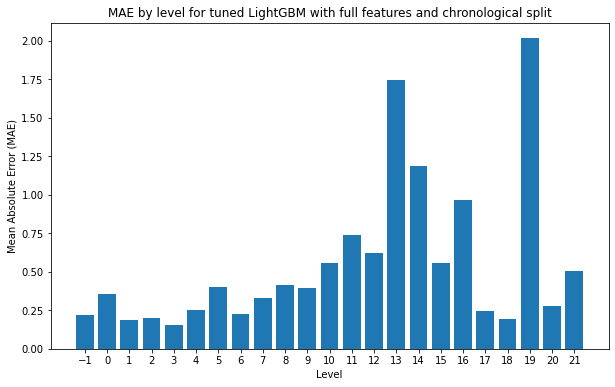

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.57

Round type: 0.5
RMSE: 0.58

Round type: 0.33
RMSE: 0.56

Round type: 0.45
RMSE: 0.58



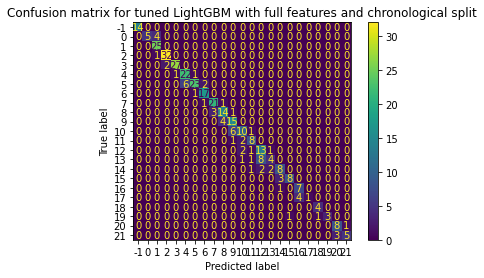

In [29]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.246737	valid_0's l2: 0.1379


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.37
MAE: 0.25


In [33]:
results.loc[2] = ["random", "default", "full", rmse, mae]

###### MAE by level

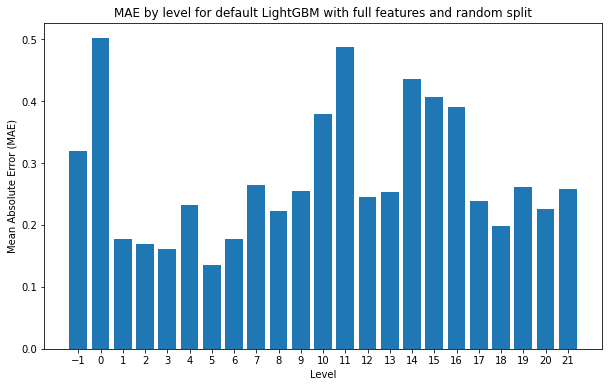

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and random split",
)

In [35]:
check_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.37

Round type: 0.5
RMSE: 0.38

Round type: 0.33
RMSE: 0.43

Round type: 0.45
RMSE: 0.38



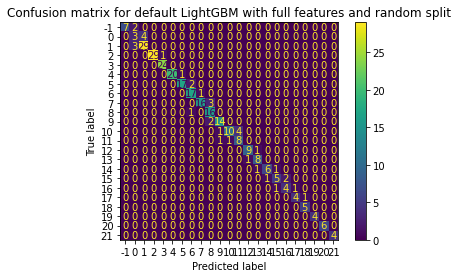

In [36]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with full features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 14:05:34,352] A new study created in memory with name: no-name-8bc02465-77bf-436c-a466-ce3df5c9746e
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.169779 + 0.0512793
[200]	cv_agg's l2: 0.164047 + 0.0476074
[300]	cv_agg's l2: 0.162921 + 0.0465607
[400]	cv_agg's l2: 0.16284 + 0.0463917
[500]	cv_agg's l2: 0.162423 + 0.0460353
[600]	cv_agg's l2: 0.162313 + 0.0459229
[700]	cv_agg's l2: 0.162235 + 0.0457002


feature_fraction, val_score: 0.162230:  14%|######4                                      | 1/7 [00:05<00:31,  5.24s/it]

[800]	cv_agg's l2: 0.162275 + 0.0457673
Early stopping, best iteration is:
[714]	cv_agg's l2: 0.16223 + 0.0457438
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


feature_fraction, val_score: 0.132052:  29%|############8                                | 2/7 [00:13<00:34,  6.99s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.162568 + 0.050186
[200]	cv_agg's l2: 0.158736 + 0.049075
[300]	cv_agg's l2: 0.157619 + 0.0479239
[400]	cv_agg's l2: 0.157196 + 0.0475804
[500]	cv_agg's l2: 0.156857 + 0.0471636
[600]	cv_agg's l2: 0.1566 + 0.0467607
[700]	cv_agg's l2: 0.15656 + 0.0466386
[800]	cv_agg's l2: 0.156559 + 0.0465701
[900]	cv_agg's l2: 0.156512 + 0.046468
[1000]	cv_agg's l2: 0.156522 + 0.0464151
[1100]	cv_agg's l2: 0.156527 + 0.0463976
[1200]	cv_agg's l2: 0.156531 + 0.046367


feature_fraction, val_score: 0.132052:  43%|###################2                         | 3/7 [00:21<00:29,  7.38s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.173104 + 0.0409861
[200]	cv_agg's l2: 0.169018 + 0.0386093
[300]	cv_agg's l2: 0.167683 + 0.0377418
[400]	cv_agg's l2: 0.167287 + 0.0375598
[500]	cv_agg's l2: 0.167278 + 0.0373334
[600]	cv_agg's l2: 0.167403 + 0.0373001
[700]	cv_agg's l2: 0.16737 + 0.0372613
[800]	cv_agg's l2: 0.167335 + 0.0372178
[900]	cv_agg's l2: 0.167404 + 0.037219
[1000]	cv_agg's l2: 0.16744 + 0.0372303
[1100]	cv_agg's l2: 0.167438 + 0.0372002
[1200]	cv_agg's l2: 0.167399 + 0.0371402


feature_fraction, val_score: 0.132052:  57%|#########################7                   | 4/7 [00:29<00:22,  7.56s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.171474 + 0.0470364
[200]	cv_agg's l2: 0.166536 + 0.0461847
[300]	cv_agg's l2: 0.16537 + 0.0454758
[400]	cv_agg's l2: 0.164967 + 0.0453036
[500]	cv_agg's l2: 0.164869 + 0.0451928
[600]	cv_agg's l2: 0.164859 + 0.045158
[700]	cv_agg's l2: 0.164841 + 0.0451886
[800]	cv_agg's l2: 0.164808 + 0.0451013
[900]	cv_agg's l2: 0.164823 + 0.0451003
[1000]	cv_agg's l2: 0.164831 + 0.0450991
[1100]	cv_agg's l2: 0.164833 + 0.0451137
[1200]	cv_agg's l2: 0.164849 + 0.0450947


feature_fraction, val_score: 0.132052:  71%|################################1            | 5/7 [00:37<00:15,  7.80s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.156599 + 0.0440737
[200]	cv_agg's l2: 0.152929 + 0.0427997
[300]	cv_agg's l2: 0.152166 + 0.0423426
[400]	cv_agg's l2: 0.15182 + 0.0419162
[500]	cv_agg's l2: 0.15157 + 0.0415837
[600]	cv_agg's l2: 0.151441 + 0.0415139
[700]	cv_agg's l2: 0.151454 + 0.0415199
[800]	cv_agg's l2: 0.151495 + 0.0415521
[900]	cv_agg's l2: 0.151495 + 0.0415312
[1000]	cv_agg's l2: 0.151493 + 0.0414923
[1100]	cv_agg's l2: 0.151476 + 0.0414722
[1200]	cv_agg's l2: 0.151471 + 0.0414687


feature_fraction, val_score: 0.132052:  86%|######################################5      | 6/7 [00:45<00:08,  8.04s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.14661 + 0.0384955
[200]	cv_agg's l2: 0.14317 + 0.0369486
[300]	cv_agg's l2: 0.142157 + 0.0371392
[400]	cv_agg's l2: 0.141799 + 0.0370335
[500]	cv_agg's l2: 0.141461 + 0.0369785
[600]	cv_agg's l2: 0.141374 + 0.0370912
[700]	cv_agg's l2: 0.141249 + 0.037109
[800]	cv_agg's l2: 0.141186 + 0.0369735
[900]	cv_agg's l2: 0.141177 + 0.0369422
[1000]	cv_agg's l2: 0.141226 + 0.0369592
[1100]	cv_agg's l2: 0.141245 + 0.0369675
[1200]	cv_agg's l2: 0.141264 + 0.0369485


feature_fraction, val_score: 0.132052: 100%|#############################################| 7/7 [00:54<00:00,  7.77s/it]


Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898


num_leaves, val_score: 0.132052:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:   5%|##5                                               | 1/20 [00:08<02:40,  8.43s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  10%|#####                                             | 2/20 [00:17<02:33,  8.55s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  15%|#######5                                          | 3/20 [00:25<02:25,  8.57s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.200005 + 0.0426016
[200]	cv_agg's l2: 0.182558 + 0.0361509
[300]	cv_agg's l2: 0.173642 + 0.0334622
[400]	cv_agg's l2: 0.168584 + 0.0321082
[500]	cv_agg's l2: 0.166036 + 0.0304379
[600]	cv_agg's l2: 0.164027 + 0.030141
[700]	cv_agg's l2: 0.1618 + 0.0300197
[800]	cv_agg's l2: 0.161187 + 0.0293559
[900]	cv_agg's l2: 0.159933 + 0.0283527
[1000]	cv_agg's l2: 0.159285 + 0.0279779
[1100]	cv_agg's l2: 0.15815 + 0.0275156
[1200]	cv_agg's l2: 0.157361 + 0.0277063
Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898


num_leaves, val_score: 0.132052:  20%|##########                                        | 4/20 [00:28<01:42,  6.39s/it]

[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  25%|############5                                     | 5/20 [00:36<01:45,  7.02s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  30%|###############                                   | 6/20 [00:45<01:44,  7.43s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  35%|#################5                                | 7/20 [00:53<01:41,  7.82s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  40%|####################                              | 8/20 [01:03<01:39,  8.32s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  45%|######################5                           | 9/20 [01:11<01:31,  8.32s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.200005 + 0.0426016
[200]	cv_agg's l2: 0.182558 + 0.0361509
[300]	cv_agg's l2: 0.173642 + 0.0334622
[400]	cv_agg's l2: 0.168584 + 0.0321082
[500]	cv_agg's l2: 0.166036 + 0.0304379
[600]	cv_agg's l2: 0.164027 + 0.030141
[700]	cv_agg's l2: 0.1618 + 0.0300197
[800]	cv_agg's l2: 0.161187 + 0.0293559
[900]	cv_agg's l2: 0.159933 + 0.0283527
[1000]	cv_agg's l2: 0.159285 + 0.0279779
[1100]	cv_agg's l2: 0.15815 + 0.0275156


num_leaves, val_score: 0.132052:  45%|######################5                           | 9/20 [01:14<01:31,  8.32s/it]

[1200]	cv_agg's l2: 0.157361 + 0.0277063
Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898


num_leaves, val_score: 0.132052:  50%|########################5                        | 10/20 [01:14<01:06,  6.69s/it]

[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  55%|##########################9                      | 11/20 [01:23<01:06,  7.40s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  60%|#############################4                   | 12/20 [01:31<01:01,  7.70s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  65%|###############################8                 | 13/20 [01:40<00:56,  8.02s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  70%|##################################3              | 14/20 [01:51<00:52,  8.76s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  75%|####################################7            | 15/20 [02:03<00:48,  9.73s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  80%|#######################################2         | 16/20 [02:11<00:37,  9.35s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  85%|#########################################6       | 17/20 [02:20<00:28,  9.36s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  90%|############################################1    | 18/20 [02:34<00:20, 10.50s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052:  95%|##############################################5  | 19/20 [02:48<00:11, 11.77s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132541 + 0.0293922
[500]	cv_agg's l2: 0.132435 + 0.0293248
[600]	cv_agg's l2: 0.132339 + 0.0291518
[700]	cv_agg's l2: 0.132317 + 0.0290427
[800]	cv_agg's l2: 0.132229 + 0.0289264
[900]	cv_agg's l2: 0.132146 + 0.0288244
[1000]	cv_agg's l2: 0.132121 + 0.0287781
[1100]	cv_agg's l2: 0.132068 + 0.0287227
[1200]	cv_agg's l2: 0.132058 + 0.0286909


num_leaves, val_score: 0.132052: 100%|#################################################| 20/20 [03:01<00:00,  9.06s/it]


Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898


bagging, val_score: 0.132052:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145041 + 0.0247977
[200]	cv_agg's l2: 0.138674 + 0.0241853
[300]	cv_agg's l2: 0.137341 + 0.0251152
[400]	cv_agg's l2: 0.136442 + 0.0258071
[500]	cv_agg's l2: 0.136558 + 0.0263824
[600]	cv_agg's l2: 0.136296 + 0.0263324
[700]	cv_agg's l2: 0.13637 + 0.0264377
[800]	cv_agg's l2: 0.136151 + 0.0265615
[900]	cv_agg's l2: 0.13612 + 0.0266558
[1000]	cv_agg's l2: 0.136103 + 0.0267595
[1100]	cv_agg's l2: 0.136028 + 0.0268147
[1200]	cv_agg's l2: 0.135932 + 0.0267447


bagging, val_score: 0.132052:  10%|#####3                                               | 1/10 [00:09<01:22,  9.18s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.201651 + 0.0253954
[200]	cv_agg's l2: 0.189573 + 0.0171129
[300]	cv_agg's l2: 0.18875 + 0.0193435
[400]	cv_agg's l2: 0.184676 + 0.017388
[500]	cv_agg's l2: 0.182915 + 0.0162477
[600]	cv_agg's l2: 0.181771 + 0.0158015
[700]	cv_agg's l2: 0.182415 + 0.0146023
[800]	cv_agg's l2: 0.183844 + 0.0172825
[900]	cv_agg's l2: 0.18341 + 0.0175628
[1000]	cv_agg's l2: 0.183906 + 0.0188355
[1100]	cv_agg's l2: 0.183924 + 0.0178824
[1200]	cv_agg's l2: 0.183556 + 0.0163923


bagging, val_score: 0.132052:  20%|##########6                                          | 2/10 [00:14<00:54,  6.78s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.144943 + 0.0269538
[200]	cv_agg's l2: 0.141929 + 0.0294997
[300]	cv_agg's l2: 0.140894 + 0.0305092
[400]	cv_agg's l2: 0.140719 + 0.0307741
[500]	cv_agg's l2: 0.140634 + 0.0310434
[600]	cv_agg's l2: 0.140467 + 0.0310034
[700]	cv_agg's l2: 0.14036 + 0.0310053
[800]	cv_agg's l2: 0.14026 + 0.0310138
[900]	cv_agg's l2: 0.140256 + 0.0309628
[1000]	cv_agg's l2: 0.140282 + 0.0309638
[1100]	cv_agg's l2: 0.140233 + 0.0309263
[1200]	cv_agg's l2: 0.140204 + 0.0308685


bagging, val_score: 0.132052:  30%|###############9                                     | 3/10 [00:24<00:58,  8.43s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.20266 + 0.0235687
[200]	cv_agg's l2: 0.194228 + 0.0213397
[300]	cv_agg's l2: 0.19126 + 0.0228551
[400]	cv_agg's l2: 0.189261 + 0.0213223
[500]	cv_agg's l2: 0.189613 + 0.0227095
[600]	cv_agg's l2: 0.187269 + 0.0208086
[700]	cv_agg's l2: 0.188089 + 0.0212767
[800]	cv_agg's l2: 0.18759 + 0.0245341
[900]	cv_agg's l2: 0.187764 + 0.0245854
[1000]	cv_agg's l2: 0.187801 + 0.0233603
[1100]	cv_agg's l2: 0.187096 + 0.0222078
[1200]	cv_agg's l2: 0.187139 + 0.0218968


bagging, val_score: 0.132052:  40%|#####################2                               | 4/10 [00:31<00:46,  7.72s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.140899 + 0.024829
[200]	cv_agg's l2: 0.137822 + 0.0251995
[300]	cv_agg's l2: 0.136365 + 0.0252566
[400]	cv_agg's l2: 0.136056 + 0.025547
[500]	cv_agg's l2: 0.135888 + 0.0255722
[600]	cv_agg's l2: 0.135663 + 0.0256114
[700]	cv_agg's l2: 0.135757 + 0.0255726
[800]	cv_agg's l2: 0.135711 + 0.0255482
[900]	cv_agg's l2: 0.135585 + 0.0254429
[1000]	cv_agg's l2: 0.135555 + 0.0254035
[1100]	cv_agg's l2: 0.135523 + 0.0253443
[1200]	cv_agg's l2: 0.135498 + 0.0253256


bagging, val_score: 0.132052:  50%|##########################5                          | 5/10 [00:40<00:42,  8.40s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.165628 + 0.0335446
[200]	cv_agg's l2: 0.157646 + 0.0287276
[300]	cv_agg's l2: 0.153294 + 0.0280146
[400]	cv_agg's l2: 0.151512 + 0.0280236
[500]	cv_agg's l2: 0.150183 + 0.0273049
[600]	cv_agg's l2: 0.149362 + 0.0274464
[700]	cv_agg's l2: 0.148636 + 0.0275155
[800]	cv_agg's l2: 0.148317 + 0.0282564
[900]	cv_agg's l2: 0.148094 + 0.0285881
[1000]	cv_agg's l2: 0.147919 + 0.0283114
[1100]	cv_agg's l2: 0.148098 + 0.0283069
[1200]	cv_agg's l2: 0.148031 + 0.028538


bagging, val_score: 0.132052:  60%|###############################8                     | 6/10 [00:47<00:31,  7.86s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.169011 + 0.0450119
[200]	cv_agg's l2: 0.160278 + 0.0387703
[300]	cv_agg's l2: 0.157939 + 0.0396833
[400]	cv_agg's l2: 0.156692 + 0.0388119
[500]	cv_agg's l2: 0.154762 + 0.038524
[600]	cv_agg's l2: 0.154428 + 0.0383835
[700]	cv_agg's l2: 0.153873 + 0.0391464
[800]	cv_agg's l2: 0.153873 + 0.0392345
[900]	cv_agg's l2: 0.153127 + 0.0389547
[1000]	cv_agg's l2: 0.153165 + 0.0393652
[1100]	cv_agg's l2: 0.1528 + 0.0390791
[1200]	cv_agg's l2: 0.15283 + 0.0394345


bagging, val_score: 0.132052:  70%|#####################################                | 7/10 [00:53<00:21,  7.28s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.151206 + 0.0380639
[200]	cv_agg's l2: 0.146447 + 0.0367963
[300]	cv_agg's l2: 0.14469 + 0.0363363
[400]	cv_agg's l2: 0.144096 + 0.0367998
[500]	cv_agg's l2: 0.143638 + 0.0368278
[600]	cv_agg's l2: 0.143495 + 0.0371152
[700]	cv_agg's l2: 0.143435 + 0.0372116
[800]	cv_agg's l2: 0.143284 + 0.0375131
[900]	cv_agg's l2: 0.143197 + 0.0373013
[1000]	cv_agg's l2: 0.143201 + 0.0374285
[1100]	cv_agg's l2: 0.14308 + 0.0375074
[1200]	cv_agg's l2: 0.142999 + 0.0373712


bagging, val_score: 0.132052:  80%|##########################################4          | 8/10 [01:03<00:15,  7.97s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.174984 + 0.0266775
[200]	cv_agg's l2: 0.168613 + 0.0247389
[300]	cv_agg's l2: 0.167786 + 0.0268934
[400]	cv_agg's l2: 0.168908 + 0.0274119
[500]	cv_agg's l2: 0.165971 + 0.0279633
[600]	cv_agg's l2: 0.164259 + 0.0285282
[700]	cv_agg's l2: 0.164194 + 0.0277412
[800]	cv_agg's l2: 0.16357 + 0.0281718
[900]	cv_agg's l2: 0.163433 + 0.028983
[1000]	cv_agg's l2: 0.162668 + 0.0289465
[1100]	cv_agg's l2: 0.162744 + 0.0288745
[1200]	cv_agg's l2: 0.162406 + 0.0280308


bagging, val_score: 0.132052:  90%|###############################################7     | 9/10 [01:10<00:07,  7.80s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.145901 + 0.0294657
[200]	cv_agg's l2: 0.142428 + 0.0304821
[300]	cv_agg's l2: 0.141172 + 0.0310999
[400]	cv_agg's l2: 0.140276 + 0.0310298
[500]	cv_agg's l2: 0.140041 + 0.0312337
[600]	cv_agg's l2: 0.139923 + 0.0312226
[700]	cv_agg's l2: 0.139922 + 0.0311648
[800]	cv_agg's l2: 0.139838 + 0.0311671
[900]	cv_agg's l2: 0.139716 + 0.0311663
[1000]	cv_agg's l2: 0.139504 + 0.0310359
[1100]	cv_agg's l2: 0.139518 + 0.031046
[1200]	cv_agg's l2: 0.139581 + 0.0310425


bagging, val_score: 0.132052: 100%|####################################################| 10/10 [01:19<00:00,  7.94s/it]


Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898


feature_fraction_stage2, val_score: 0.132052:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.138332 + 0.0353495
[200]	cv_agg's l2: 0.135845 + 0.0337624
[300]	cv_agg's l2: 0.136075 + 0.03407
[400]	cv_agg's l2: 0.13622 + 0.0345463
[500]	cv_agg's l2: 0.136178 + 0.0344975
[600]	cv_agg's l2: 0.136276 + 0.0345436
[700]	cv_agg's l2: 0.136232 + 0.0344403
[800]	cv_agg's l2: 0.136199 + 0.0343962
[900]	cv_agg's l2: 0.136236 + 0.0344043
[1000]	cv_agg's l2: 0.136288 + 0.0344016
[1100]	cv_agg's l2: 0.136303 + 0.0343755
[1200]	cv_agg's l2: 0.136334 + 0.0344072


feature_fraction_stage2, val_score: 0.132052:  33%|############6                         | 1/3 [00:10<00:21, 10.91s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.137367 + 0.0329556
[200]	cv_agg's l2: 0.134408 + 0.0325202
[300]	cv_agg's l2: 0.134032 + 0.0331437
[400]	cv_agg's l2: 0.133836 + 0.0328249
[500]	cv_agg's l2: 0.133618 + 0.0327483
[600]	cv_agg's l2: 0.133526 + 0.0326035
[700]	cv_agg's l2: 0.133461 + 0.0324727
[800]	cv_agg's l2: 0.13346 + 0.0323973
[900]	cv_agg's l2: 0.133344 + 0.032279
[1000]	cv_agg's l2: 0.133323 + 0.032247
[1100]	cv_agg's l2: 0.133316 + 0.0322487
[1200]	cv_agg's l2: 0.133307 + 0.0322206


feature_fraction_stage2, val_score: 0.132052:  67%|#########################3            | 2/3 [00:21<00:10, 10.66s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.146079 + 0.0374343
[200]	cv_agg's l2: 0.143146 + 0.0358445
[300]	cv_agg's l2: 0.142002 + 0.0354292
[400]	cv_agg's l2: 0.141887 + 0.0357818
[500]	cv_agg's l2: 0.141594 + 0.0353795
[600]	cv_agg's l2: 0.141507 + 0.0353585
[700]	cv_agg's l2: 0.141461 + 0.0353216
[800]	cv_agg's l2: 0.141374 + 0.0352861
[900]	cv_agg's l2: 0.141384 + 0.0352673
[1000]	cv_agg's l2: 0.141352 + 0.0352121
[1100]	cv_agg's l2: 0.141367 + 0.0351998
[1200]	cv_agg's l2: 0.141402 + 0.035254


feature_fraction_stage2, val_score: 0.132052: 100%|######################################| 3/3 [00:31<00:00, 10.62s/it]


Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898


regularization_factors, val_score: 0.132052:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.138193 + 0.0304932
[200]	cv_agg's l2: 0.135366 + 0.0309064
[300]	cv_agg's l2: 0.135248 + 0.0311161
[400]	cv_agg's l2: 0.134796 + 0.0308095
[500]	cv_agg's l2: 0.134566 + 0.0305592
[600]	cv_agg's l2: 0.134409 + 0.0303961
[700]	cv_agg's l2: 0.134247 + 0.030191
[800]	cv_agg's l2: 0.13423 + 0.0301754
[900]	cv_agg's l2: 0.134213 + 0.0301598
[1000]	cv_agg's l2: 0.13422 + 0.0301314
[1100]	cv_agg's l2: 0.134174 + 0.030098
[1200]	cv_agg's l2: 0.13414 + 0.0300596


regularization_factors, val_score: 0.132052:   5%|#9                                    | 1/20 [00:14<04:36, 14.56s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.182075 + 0.0412593
[200]	cv_agg's l2: 0.178117 + 0.0397679
[300]	cv_agg's l2: 0.178106 + 0.0397669
[400]	cv_agg's l2: 0.178105 + 0.0397674
[500]	cv_agg's l2: 0.178105 + 0.0397674
[600]	cv_agg's l2: 0.178105 + 0.0397674
[700]	cv_agg's l2: 0.178105 + 0.0397674
[800]	cv_agg's l2: 0.178105 + 0.0397674
[900]	cv_agg's l2: 0.178105 + 0.0397674
[1000]	cv_agg's l2: 0.178105 + 0.0397674
[1100]	cv_agg's l2: 0.178105 + 0.0397674


regularization_factors, val_score: 0.132052:   5%|#9                                    | 1/20 [00:17<04:36, 14.56s/it]

[1200]	cv_agg's l2: 0.178105 + 0.0397674
Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898


regularization_factors, val_score: 0.132052:  10%|###8                                  | 2/20 [00:17<02:18,  7.68s/it]

[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134383 + 0.0293884
[300]	cv_agg's l2: 0.133005 + 0.0292928
[400]	cv_agg's l2: 0.132696 + 0.0295856
[500]	cv_agg's l2: 0.132522 + 0.0294313
[600]	cv_agg's l2: 0.132471 + 0.0293145
[700]	cv_agg's l2: 0.132414 + 0.0291618
[800]	cv_agg's l2: 0.132331 + 0.0290517
[900]	cv_agg's l2: 0.132284 + 0.0289762
[1000]	cv_agg's l2: 0.132242 + 0.0288972
[1100]	cv_agg's l2: 0.132201 + 0.0288299
[1200]	cv_agg's l2: 0.132183 + 0.0287992


regularization_factors, val_score: 0.132052:  15%|#####7                                | 3/20 [00:27<02:27,  8.69s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.157333 + 0.0305782
[200]	cv_agg's l2: 0.148476 + 0.0305845
[300]	cv_agg's l2: 0.146296 + 0.0305733
[400]	cv_agg's l2: 0.145503 + 0.0311751
[500]	cv_agg's l2: 0.144939 + 0.0313976
[600]	cv_agg's l2: 0.144585 + 0.0314574
[700]	cv_agg's l2: 0.144172 + 0.0314403
[800]	cv_agg's l2: 0.14395 + 0.0316354
[900]	cv_agg's l2: 0.143835 + 0.0317248
[1000]	cv_agg's l2: 0.143791 + 0.0318021
[1100]	cv_agg's l2: 0.143732 + 0.0318935
[1200]	cv_agg's l2: 0.143692 + 0.0319085


regularization_factors, val_score: 0.132052:  20%|#######6                              | 4/20 [00:37<02:28,  9.30s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.155189 + 0.0351622
[200]	cv_agg's l2: 0.150954 + 0.0347562
[300]	cv_agg's l2: 0.150955 + 0.0347616
[400]	cv_agg's l2: 0.150956 + 0.034762
[500]	cv_agg's l2: 0.150956 + 0.034762
[600]	cv_agg's l2: 0.150956 + 0.034762
[700]	cv_agg's l2: 0.150956 + 0.034762
[800]	cv_agg's l2: 0.150956 + 0.034762
[900]	cv_agg's l2: 0.150956 + 0.034762
[1000]	cv_agg's l2: 0.150956 + 0.034762
[1100]	cv_agg's l2: 0.150956 + 0.034762
[1200]	cv_agg's l2: 0.150956 + 0.034762


regularization_factors, val_score: 0.132052:  25%|#########5                            | 5/20 [00:40<01:45,  7.06s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.137464 + 0.0317117
[200]	cv_agg's l2: 0.134771 + 0.031925
[300]	cv_agg's l2: 0.133971 + 0.0322838
[400]	cv_agg's l2: 0.133898 + 0.032158
[500]	cv_agg's l2: 0.133451 + 0.0319247
[600]	cv_agg's l2: 0.133262 + 0.0317791
[700]	cv_agg's l2: 0.133246 + 0.0318025
[800]	cv_agg's l2: 0.133176 + 0.0317547
[900]	cv_agg's l2: 0.133127 + 0.0316941
[1000]	cv_agg's l2: 0.133107 + 0.031641
[1100]	cv_agg's l2: 0.133066 + 0.031556
[1200]	cv_agg's l2: 0.133073 + 0.0315124


regularization_factors, val_score: 0.132052:  30%|###########4                          | 6/20 [00:51<01:58,  8.45s/it]

Early stopping, best iteration is:
[1171]	cv_agg's l2: 0.132052 + 0.0286898
[100]	cv_agg's l2: 0.136097 + 0.0283865
[200]	cv_agg's l2: 0.131789 + 0.0277202
[300]	cv_agg's l2: 0.131188 + 0.0277702
[400]	cv_agg's l2: 0.13096 + 0.0275983
[500]	cv_agg's l2: 0.130809 + 0.0273935
[600]	cv_agg's l2: 0.130753 + 0.0274298
[700]	cv_agg's l2: 0.130596 + 0.0272339


regularization_factors, val_score: 0.130549:  35%|#############3                        | 7/20 [00:58<01:40,  7.75s/it]

[800]	cv_agg's l2: 0.130657 + 0.0272429
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.136635 + 0.0301032
[200]	cv_agg's l2: 0.134487 + 0.0305105
[300]	cv_agg's l2: 0.133886 + 0.0310253
[400]	cv_agg's l2: 0.133929 + 0.0309116
[500]	cv_agg's l2: 0.133683 + 0.0307598
[600]	cv_agg's l2: 0.133597 + 0.0306875
[700]	cv_agg's l2: 0.133489 + 0.0306094


regularization_factors, val_score: 0.130549:  40%|###############2                      | 8/20 [01:04<01:27,  7.27s/it]

[800]	cv_agg's l2: 0.133428 + 0.0305836
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.137459 + 0.0290202
[200]	cv_agg's l2: 0.135091 + 0.028912
[300]	cv_agg's l2: 0.134668 + 0.0289316
[400]	cv_agg's l2: 0.134395 + 0.0285044
[500]	cv_agg's l2: 0.134352 + 0.0282667
[600]	cv_agg's l2: 0.134086 + 0.0280313
[700]	cv_agg's l2: 0.13401 + 0.0279371


regularization_factors, val_score: 0.130549:  45%|#################1                    | 9/20 [01:12<01:21,  7.41s/it]

[800]	cv_agg's l2: 0.134001 + 0.0278857
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.13722 + 0.0296393
[200]	cv_agg's l2: 0.134515 + 0.0293575
[300]	cv_agg's l2: 0.133233 + 0.029309
[400]	cv_agg's l2: 0.132667 + 0.02902
[500]	cv_agg's l2: 0.132392 + 0.0289099
[600]	cv_agg's l2: 0.132285 + 0.0288522
[700]	cv_agg's l2: 0.132088 + 0.0286681


regularization_factors, val_score: 0.130549:  50%|##################5                  | 10/20 [01:18<01:12,  7.23s/it]

[800]	cv_agg's l2: 0.132092 + 0.0285238
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.136426 + 0.0286672
[200]	cv_agg's l2: 0.132815 + 0.0285148
[300]	cv_agg's l2: 0.132196 + 0.0289718
[400]	cv_agg's l2: 0.132037 + 0.0290035
[500]	cv_agg's l2: 0.132014 + 0.0288794
[600]	cv_agg's l2: 0.13201 + 0.0289184
[700]	cv_agg's l2: 0.131843 + 0.0287952


regularization_factors, val_score: 0.130549:  55%|####################3                | 11/20 [01:25<01:03,  7.11s/it]

[800]	cv_agg's l2: 0.131824 + 0.0287577
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.13705 + 0.0307569
[200]	cv_agg's l2: 0.134685 + 0.0299577
[300]	cv_agg's l2: 0.133959 + 0.0299505
[400]	cv_agg's l2: 0.133609 + 0.0299551
[500]	cv_agg's l2: 0.133423 + 0.0296634
[600]	cv_agg's l2: 0.133342 + 0.0293987
[700]	cv_agg's l2: 0.133231 + 0.0292921


regularization_factors, val_score: 0.130549:  60%|######################2              | 12/20 [01:31<00:54,  6.76s/it]

[800]	cv_agg's l2: 0.133215 + 0.0292596
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.139127 + 0.0304447
[200]	cv_agg's l2: 0.134994 + 0.0291106
[300]	cv_agg's l2: 0.134831 + 0.029361
[400]	cv_agg's l2: 0.13455 + 0.0292358
[500]	cv_agg's l2: 0.134352 + 0.0291488
[600]	cv_agg's l2: 0.134335 + 0.0291519


regularization_factors, val_score: 0.130549:  60%|######################2              | 12/20 [01:35<00:54,  6.76s/it]

[700]	cv_agg's l2: 0.134335 + 0.0291519
[800]	cv_agg's l2: 0.134335 + 0.0291519
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327


regularization_factors, val_score: 0.130549:  65%|########################             | 13/20 [01:35<00:40,  5.81s/it]

[100]	cv_agg's l2: 0.138118 + 0.030199
[200]	cv_agg's l2: 0.135305 + 0.0317043
[300]	cv_agg's l2: 0.134454 + 0.0313946
[400]	cv_agg's l2: 0.134203 + 0.0318191
[500]	cv_agg's l2: 0.133935 + 0.03146
[600]	cv_agg's l2: 0.133701 + 0.0314939
[700]	cv_agg's l2: 0.133553 + 0.0313041


regularization_factors, val_score: 0.130549:  70%|#########################9           | 14/20 [01:43<00:38,  6.41s/it]

[800]	cv_agg's l2: 0.133481 + 0.0312588
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.140773 + 0.0322879
[200]	cv_agg's l2: 0.136036 + 0.031333
[300]	cv_agg's l2: 0.134958 + 0.0315518
[400]	cv_agg's l2: 0.134918 + 0.0315704
[500]	cv_agg's l2: 0.134918 + 0.0315704
[600]	cv_agg's l2: 0.134918 + 0.0315704
[700]	cv_agg's l2: 0.134918 + 0.0315704


regularization_factors, val_score: 0.130549:  75%|###########################7         | 15/20 [01:45<00:26,  5.33s/it]

[800]	cv_agg's l2: 0.134918 + 0.0315704
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.136579 + 0.028418
[200]	cv_agg's l2: 0.134231 + 0.0297535
[300]	cv_agg's l2: 0.133091 + 0.0300514
[400]	cv_agg's l2: 0.13248 + 0.0298177
[500]	cv_agg's l2: 0.132268 + 0.0296763
[600]	cv_agg's l2: 0.132131 + 0.0296881
[700]	cv_agg's l2: 0.132061 + 0.0295112


regularization_factors, val_score: 0.130549:  80%|#############################6       | 16/20 [01:52<00:22,  5.58s/it]

[800]	cv_agg's l2: 0.132069 + 0.0294406
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.137424 + 0.029835
[200]	cv_agg's l2: 0.134435 + 0.0302148
[300]	cv_agg's l2: 0.133344 + 0.0310121
[400]	cv_agg's l2: 0.133172 + 0.0308045
[500]	cv_agg's l2: 0.133205 + 0.0306471
[600]	cv_agg's l2: 0.133055 + 0.0305734
[700]	cv_agg's l2: 0.132981 + 0.0304749


regularization_factors, val_score: 0.130549:  85%|###############################4     | 17/20 [01:58<00:17,  5.73s/it]

[800]	cv_agg's l2: 0.132898 + 0.0303841
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.136689 + 0.0288464
[200]	cv_agg's l2: 0.134509 + 0.0298728
[300]	cv_agg's l2: 0.133203 + 0.0301906
[400]	cv_agg's l2: 0.132891 + 0.030292
[500]	cv_agg's l2: 0.132544 + 0.0301759
[600]	cv_agg's l2: 0.132403 + 0.0300979
[700]	cv_agg's l2: 0.132278 + 0.0300497


regularization_factors, val_score: 0.130549:  90%|#################################3   | 18/20 [02:03<00:11,  5.72s/it]

[800]	cv_agg's l2: 0.132206 + 0.0300284
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.139525 + 0.0303393
[200]	cv_agg's l2: 0.136266 + 0.0293337
[300]	cv_agg's l2: 0.135307 + 0.0298203
[400]	cv_agg's l2: 0.134672 + 0.0299255
[500]	cv_agg's l2: 0.134451 + 0.0299299
[600]	cv_agg's l2: 0.134412 + 0.0298878
[700]	cv_agg's l2: 0.134393 + 0.0298593


regularization_factors, val_score: 0.130549:  95%|###################################1 | 19/20 [02:07<00:05,  5.03s/it]

[800]	cv_agg's l2: 0.134393 + 0.0298593
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.137684 + 0.0300045
[200]	cv_agg's l2: 0.134713 + 0.0311153
[300]	cv_agg's l2: 0.134566 + 0.0314056
[400]	cv_agg's l2: 0.134513 + 0.0316393
[500]	cv_agg's l2: 0.134246 + 0.0312711
[600]	cv_agg's l2: 0.134209 + 0.0310501
[700]	cv_agg's l2: 0.134179 + 0.030918


regularization_factors, val_score: 0.130549: 100%|#####################################| 20/20 [02:12<00:00,  6.64s/it]


[800]	cv_agg's l2: 0.13415 + 0.0308536
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327


min_data_in_leaf, val_score: 0.130549:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.214515 + 0.0186826
[200]	cv_agg's l2: 0.205307 + 0.0195981
[300]	cv_agg's l2: 0.204256 + 0.0229418
[400]	cv_agg's l2: 0.204054 + 0.0250857
[500]	cv_agg's l2: 0.205019 + 0.0263357
[600]	cv_agg's l2: 0.205391 + 0.0269083
[700]	cv_agg's l2: 0.20537 + 0.0268562


min_data_in_leaf, val_score: 0.130549:  20%|#########                                    | 1/5 [00:03<00:12,  3.06s/it]

[800]	cv_agg's l2: 0.206507 + 0.0271143
Early stopping, best iteration is:
[713]	cv_agg's l2: 0.130549 + 0.0272327
[100]	cv_agg's l2: 0.129268 + 0.0310453
[200]	cv_agg's l2: 0.127893 + 0.032051
[300]	cv_agg's l2: 0.127356 + 0.0318061
[400]	cv_agg's l2: 0.127154 + 0.0316947


min_data_in_leaf, val_score: 0.127039:  20%|#########                                    | 1/5 [00:06<00:12,  3.06s/it]

[500]	cv_agg's l2: 0.127041 + 0.0316818
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.127039 + 0.0316818


min_data_in_leaf, val_score: 0.127039:  40%|##################                           | 2/5 [00:06<00:10,  3.57s/it]

[100]	cv_agg's l2: 0.652807 + 0.0621087
[200]	cv_agg's l2: 0.619503 + 0.0573077
[300]	cv_agg's l2: 0.602576 + 0.0545561
[400]	cv_agg's l2: 0.58824 + 0.057525
[500]	cv_agg's l2: 0.578444 + 0.0570186


min_data_in_leaf, val_score: 0.127039:  60%|###########################                  | 3/5 [00:08<00:05,  2.73s/it]

Early stopping, best iteration is:
[494]	cv_agg's l2: 0.127039 + 0.0316818
[100]	cv_agg's l2: 0.13277 + 0.0361469
[200]	cv_agg's l2: 0.131009 + 0.0348948
[300]	cv_agg's l2: 0.130751 + 0.0345912
[400]	cv_agg's l2: 0.130606 + 0.0346015


min_data_in_leaf, val_score: 0.127039:  80%|####################################         | 4/5 [00:11<00:02,  2.92s/it]

[500]	cv_agg's l2: 0.130597 + 0.0346005
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.127039 + 0.0316818
[100]	cv_agg's l2: 0.147791 + 0.0358535
[200]	cv_agg's l2: 0.144837 + 0.0357076
[300]	cv_agg's l2: 0.14399 + 0.035788
[400]	cv_agg's l2: 0.143684 + 0.0358187
[500]	cv_agg's l2: 0.143309 + 0.0359908


min_data_in_leaf, val_score: 0.127039: 100%|#############################################| 5/5 [00:15<00:00,  3.08s/it]

Early stopping, best iteration is:
[494]	cv_agg's l2: 0.127039 + 0.0316818


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1270394586837299
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.03459202957711342
    lambda_l2: 1.949345794261655e-05
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.01
RMSE test: 0.30
MAE test: 0.21



In [41]:
results.loc[3] = ["random", "Optuna", "full", rmse, mae]

###### MAE by level

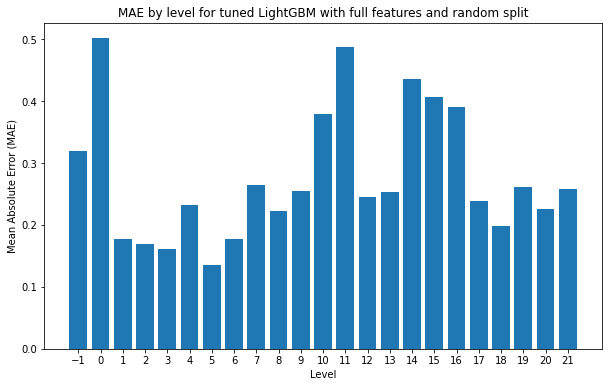

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.17

Round type: 0.5
RMSE: 0.20

Round type: 0.33
RMSE: 0.22

Round type: 0.45
RMSE: 0.20



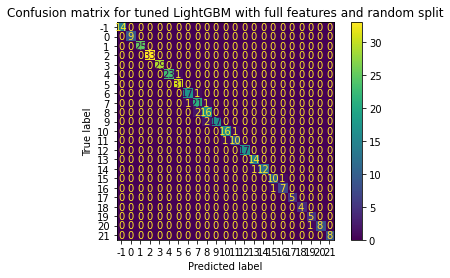

In [44]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,full,0.962960,0.460853
1,chronological,Optuna,full,0.570186,0.354511
2,random,default,full,0.371349,0.246737
3,random,Optuna,full,0.301093,0.211254


In [46]:
from training.results import plot_summary

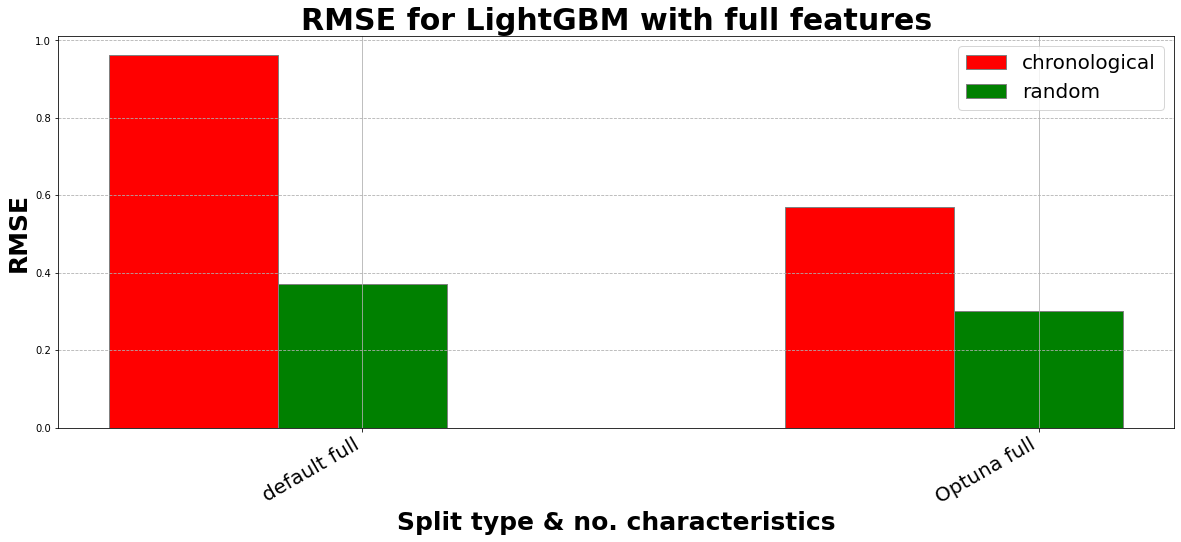

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

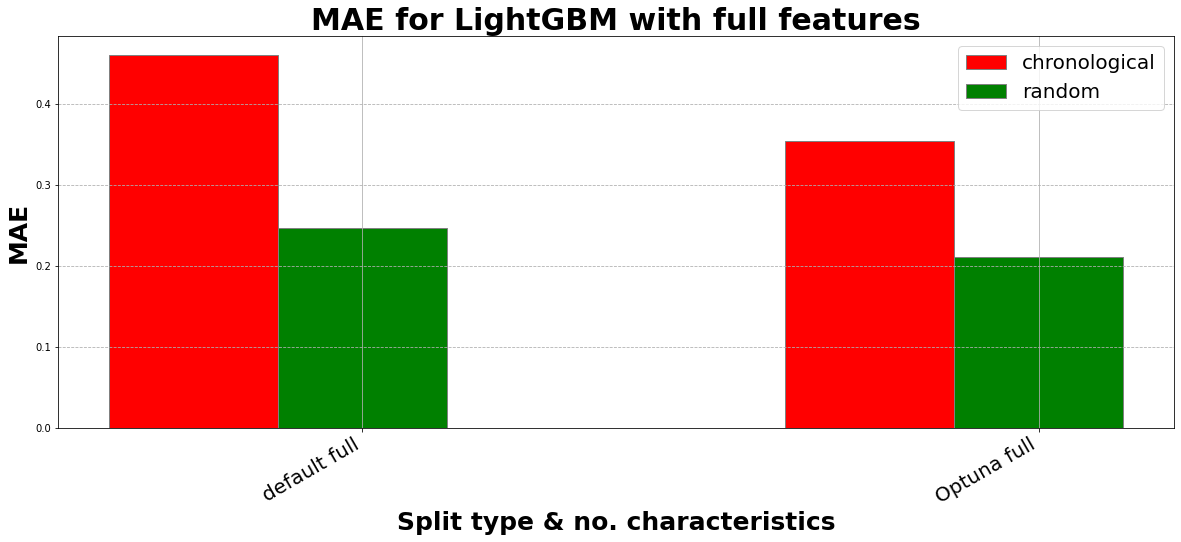

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [49]:
results.to_json("./lightgbm_full_results.json", indent=2)